# Monte Carlo Methods

In [ ]:
from IPython.lib.display import YouTubeVideo

In [ ]:
YouTubeVideo('titaMCRl224')

#### Which of the following describes the Monte Carlo approach discussed in the previous video?
- [ ] After each time step, the agent will select a different action.
- [ ] For the first episode, the agent selects the first action at every time step.  For the second episode, it selects a different action, and so on.
- [x] When the agent has a policy in mind, it follows the policy to collect a lot of episodes. Then, for each state, to figure out which action is best, the agent can look for which action tended to result in the most cumulative reward.
- [ ] When the agent has a policy in mind, it follows the policy to collect a single episode.  The agent uses the episode to tell if the policy is good or bad by looking at the cumulative reward that was received by the agent.

## MC Prediction

> **Prediction Problem**: Given a policy, how might the agent estimate the value function for that policy?

In [ ]:
YouTubeVideo('6ts9gdIS6vg')

In this video, a toy example is demonstrated where the agent collected two episodes, consolidated the information in a table, and then used the table to come up with a better policy. However, as discussed in the previous video, in real-world settings (and even for the toy example depicted here!), the agent will want to collect many more episodes, so that it can better trust the information stored in the table. In this video, two episodes are used only to simplify the example.

In [ ]:
YouTubeVideo('jR49ZyKuJ98')

#### Which of the following is true?
- [x] If the agent follows a policy for many episodes, we can use the results to directly estimate the action-value function corresponding to the same policy.
- [ ] If the agent knows the equiprobable random policy, we can use it to directly estimate the optimal policy.
- [x] The Q-table is used to estimate the action-value function.
- [ ] The action-value function is used to estimate the Q-table.

In [ ]:
YouTubeVideo('9LP6uXdmWxQ')

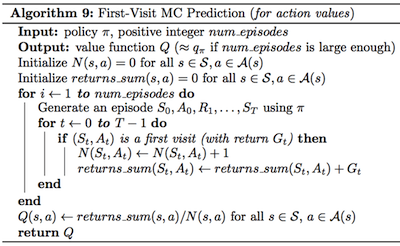

### First-visit or Every-visit
Both the first-visit and every-visit method are **guaranteed to converge** to the true action-value function, as the number of visits to each state-action pair approaches infinity. (So, in other words, _as long as the agent gets enough experience with each state-action pair, the value function estimate will be pretty close to the true value_.) In the case of first-visit MC, convergence follows from the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers), and the details are covered in section 5.1 of the textbook.

If you are interested in learning more about the difference between first-visit and every-visit MC methods, you are encouraged to read Section 3 of [this paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.32.9278&rep=rep1&type=pdf). The results are summarized in Section 3.6. The authors show:
   - Every-visit MC is [biased](https://en.wikipedia.org/wiki/Bias_of_an_estimator), whereas first-visit MC is unbiased (see Theorems 6 and 7).
   - Initially, every-visit MC has lower [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error), but as more episodes are collected, first-visit MC attains better MSE (see Corollary 9a and 10a, and Figure 4).

---

### Explore Blackjack Environment

In [ ]:
import sys
import gym
import numpy as np
from collections import defaultdict

from utils.plot_utils import plot_blackjack_values, plot_policy

The code cell below creates an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [ ]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

Execute the code cell below to play Blackjack with a random policy.

In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

#### MC Prediction

Let's write an implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.*)

In [ ]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

Now, it's time to write the implementation of MC prediction. Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):                             # loop over episodes
        if i_episode % 1000 == 0:                                          # monitor progress
            print('\rEpisode {}/{}'.format(i_episode, num_episodes), end='')
            sys.stdout.flush()
        episode = generate_episode(env)                                    # generate an episode
        states, actions, rewards = zip(*episode)                           # obtain the states, actions, and rewards
        discounts = np.array([gamma**i for i in range(len(rewards))])      # prepare for discounting
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i+1:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Greedy Policies

In [ ]:
YouTubeVideo('DH6c-aODMLU')

### Epsilon-Greedy Policies

In [ ]:
YouTubeVideo('PxJMtlR06MY')

Think of the agent who follows an $\epsilon$-greedy policy as always having a (potentially unfair) coin at its disposal, with probability $\epsilon$ of landing heads. After observing a state, the agent flips the coin.
   - If the coin lands tails (so, with probability 1-$\epsilon$), the agent selects the greedy action.
   - If the coin lands heads (so, with probability $\epsilon$), the agent selects an action *uniformly* at random from the set of available (non-greedy **AND** greedy) actions.

In order to construct a policy $\pi$ that is $\epsilon$-greedy with respect to the current action-value function estimate $Q$, we will set

$$
  \pi(a|s)=\left\{\begin{array}{lll}
    1-\epsilon+\displaystyle\frac{\epsilon}{|\mathcal{A(s)}|} & & \text{if }a\text{ maximizes } Q(s,a)\\
    \displaystyle\frac{\epsilon}{|\mathcal{A(s)}|} & & \text{else}
    \end{array}\right.
$$

---

#### Which of the values for $\epsilon$ yields an $\epsilon$-greedy policy that is guaranteed to always select the greedy action?
- [x] $\epsilon=0.0$
- [ ] $\epsilon=0.3$
- [ ] $\epsilon=0.5$
- [ ] $\epsilon=1.0$
- [ ] This is a trick question! The true answer is that none of the values for $\epsilon$ satisfy this requirement.

#### Which of the values for $\epsilon$ yields an $\epsilon$-greedy policy that is guaranteed to always select a non-greedy action?
- [ ] $\epsilon=0.0$
- [ ] $\epsilon=0.3$
- [ ] $\epsilon=0.5$
- [ ] $\epsilon=1.0$
- [x] This is a trick question! The true answer is that none of the values for $\epsilon$ satisfy this requirement.

#### Which of the values for $\epsilon$ yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy?
- [ ] $\epsilon=0.0$
- [ ] $\epsilon=0.3$
- [ ] $\epsilon=0.5$
- [x] $\epsilon=1.0$
- [ ] This is a trick question! The true answer is that none of the values for $\epsilon$ satisfy this requirement.

#### Which of the values for $\epsilon$ yields an $\epsilon$-greedy policy where the agent has the possibility of selecting a greedy action, but might select a non-greedy action instead?
- [ ] $\epsilon=0.0$
- [x] $\epsilon=0.3$
- [x] $\epsilon=0.5$
- [x] $\epsilon=1.0$
- [ ] This is a trick question! The true answer is that none of the values for $\epsilon$ satisfy this requirement.

## MC Control

> **Control Problem**: Estimate the optimal policy.

Once the Q-table closely approximates the action-value function $q_\pi$, the agent can construct the policy $\pi'$ that is $\epsilon$-greedy with respect to the Q-table, which will yield a policy that is better than the original policy $\pi$. Furthermore, if the agent alternates between these two steps, with:
  - Step 1 (**policy evaluation**): using the policy $\pi$ to construct the Q-table, and
  - Step 2 (**policy improvement**): improving the policy by changing it to be $\epsilon$-greedy with respect to the Q-table
    - $\pi'\leftarrow\epsilon$-greedy$(Q)$
    - $\pi\leftarrow\pi'$

We will eventually obtain the optimal policy $\pi^*$.

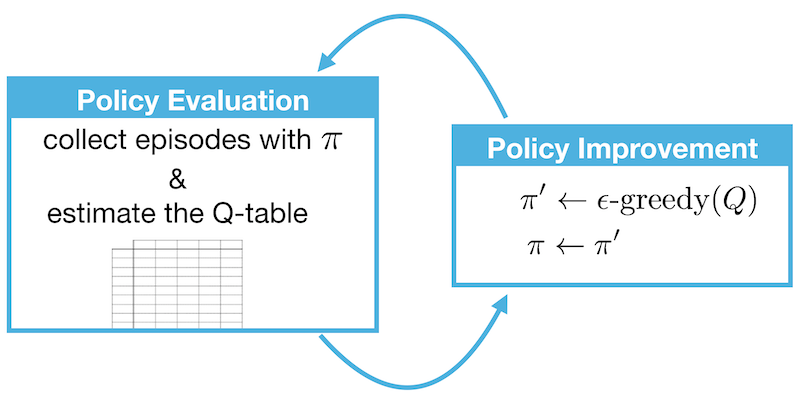

### Exploration vs. Exploitation

In many cases, we would like our RL agents to learn to maximize reward as quickly as possible. This can be seen in many OpenAI Gym environments. For instance the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment is considered solved once the agent attains an average reward of 0.78 over 100 consecutive trials. Towards this objective, it makes sense to design an algorithm that learns the optimal policy $\pi^*$ as quickly as possible.

All reinforcement learning agents face the Exploration-Exploitation Dilemma, where they must find a way to balance the drive to behave optimally based on their current knowledge (exploitation) and the need to acquire knowledge to attain better judgment (exploration).

#### Greedy in the Limit with Infinite Exploration (GLIE)

In order for MC control to converge to the optimal policy $\pi^*$, the **Greedy in the Limit with Infinite Exploration** (**GLIE**) conditions must be met:
  1. every state-action pair $s, a\quad\forall s\in\mathcal{S}\text{ and }a\in\mathcal{A}(s)$ is visited infinitely many times, and
  2. the policy converges to a policy that is greedy with respect to the action-value function estimate $Q$.

These conditions ensure that:
  - the agent continues to explore for all time steps, and
  - the agent gradually exploits more (and explores less).

One way to satisfy these conditions is to modify the value of $\epsilon$ when specifying an $\epsilon$-greedy policy. In particular, let $\epsilon_i$ correspond to the $i^{th}$ episode. Then, both of these conditions are met if:
  - $\epsilon_i>0$ for all episodes $i$, and
  - $\epsilon_i$ decays to zero in the limit as the episode $i$ approaches infinity (that is, $\displaystyle\lim_{i\to\infty}\epsilon_i=0$)
  
For example, to ensure convergence to the optimal policy, we could set $\epsilon_i=\frac{1}{i}$

In order to guarantee convergence, we must let $\epsilon_i$ decay in accordance with the **GLIE** conditions. But sometimes "guaranteed convergence" isn't good enough in practice, since this really doesn't tell you how long you have to wait! It is possible that you could need trillions of episodes to recover the optimal policy, for instance, and the "guaranteed convergence" would still be accurate!

> Even though convergence is **not** guaranteed by the mathematics, you can often get better results by either using fixed $\epsilon$ or letting $\epsilon_i$ decay linearly/non-linearly to a small positive number, like $0.1$.

As a famous example in practice, this is how the [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) algorithm sets the value of $\epsilon$.

> The behavior policy during training was $\epsilon$-greedy with $\epsilon$ annealed linearly from $1.0$ to $0.1$ over the first million frames, and fixed at $0.1$ thereafter.

#### Deterministic Policy Exploration
  1. epsilon-greedy or boltzmann exploration for discrete action
  2. addition of noise to the action itself for continuous action
  
#### Stochastic Policy Exploration
  1. entropy regularization for discrete action

### MC Control with Incremental Mean

Maybe it would be more efficient to update the Q-table after every episode. Then, the updated Q-table could be used to improve the policy. That new policy could then be used to generate the next episode, and so on.

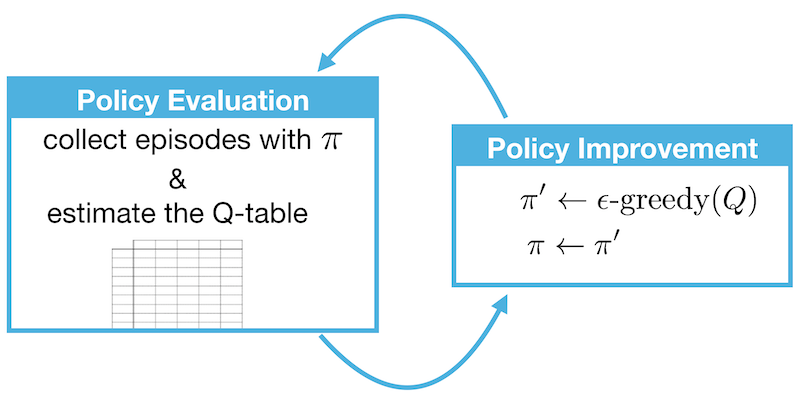

In [ ]:
YouTubeVideo('h-8MB7V1LiE')

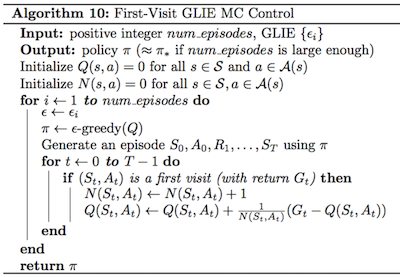

### MC Control with Constant-alpha

In [ ]:
YouTubeVideo('QFV1nI9Zpoo')

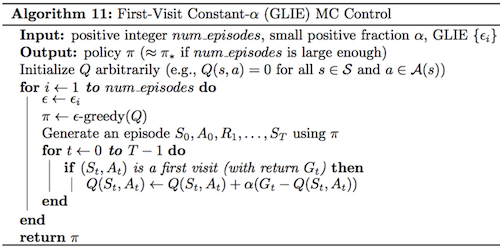

### Setting the Value of $\alpha$

In [ ]:
YouTubeVideo('LetHoOtNdJc')

Smaller values for $\alpha$ encourage the agent to consider a longer history of returns when calculating the action-value function estimate. Increasing the value of $\alpha$ ensures that the agent focuses more on the most recently sampled returns.

> **Important Note**: When implementing constant-$\alpha$ MC control, you must be careful to not set the value of $\alpha$ too close to 1. This is because very large values can keep the algorithm from converging to the optimal policy $\pi^*$. However, you must also be careful to not set the value of $\alpha$ too low, as this can result in an agent who learns too slowly. The best value of $\alpha$ for your implementation will greatly depend on your environment and is best gauged through trial-and-error.

---

In this section, we will write our own implementation of constant-$\alpha$ MC control.  

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`. 

In [ ]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    '''
    generates an episode from following the epsilon-greedy policy
    '''
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    '''
    obtains the action probabilities corresponding to epsilon-greedy policy
    '''
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    '''
    updates the action-value function estimate using the most recent episode
    '''
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    epsilon = eps_start
    for i_episode in range(1, num_episodes+1):       # loop over episodes
        if i_episode % 1000 == 0:                    # monitor progress
            print('\rEpisode {}/{}'.format(i_episode, num_episodes), end='')
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)    # set the value of epsilon
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function. You should try different values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

### plot the policy

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
plot_policy(policy)

The **true** optimal policy $\pi^*$ is show below. If your final estimate to the optimal policy is not close the the one show below, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

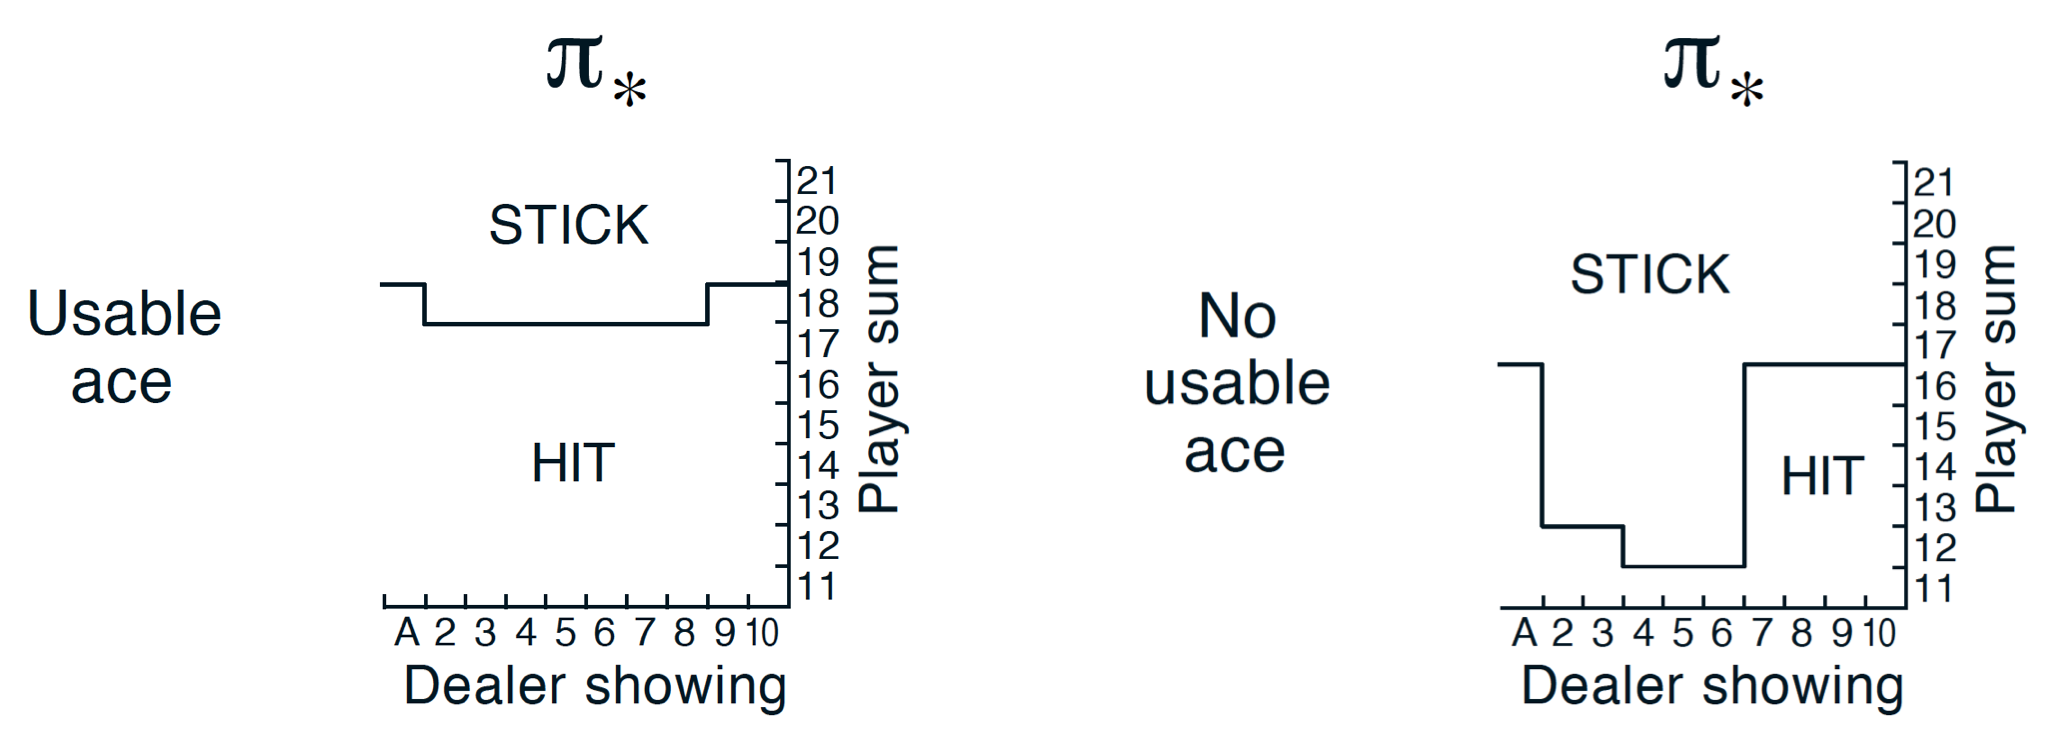

---

Next: [Temporal Difference Methods](./Temporal%20Difference%20Methods.ipynb)